In [3]:
!nvidia-smi

Fri May 24 06:58:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small # MobileNetV3Small or MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 2  # Assuming binary classification (fracture vs. non-fracture)
EPOCHS = 50
LEARNING_RATE = 0.0001

# Set the paths
MODEL_SAVE_PATH = '/content/drive/MyDrive/defense/Model details/model.h5'
MODEL_HISTORY_CSV_PATH = '/content/drive/MyDrive/defense/Model details/model_history.csv'
train_dir = '/content/drive/MyDrive/defense/brone fracture train test val/train'
validation_dir = '/content/drive/MyDrive/defense/brone fracture train test val/val'
test_dir = '/content/drive/MyDrive/defense/brone fracture train test val/test'

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Load pre-trained MobileNetV3 model
base_model = MobileNetV3Small( # or MobileNetV3Large
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Combine base model and custom head
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(MODEL_HISTORY_CSV_PATH)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // BATCH_SIZE,
    callbacks=[checkpoint, csv_logger]
)

# Save the overall CSV file
history_df = pd.DataFrame(history.history)
history_df.to_csv(MODEL_HISTORY_CSV_PATH, index=False)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // BATCH_SIZE)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Save the model
model.save(MODEL_SAVE_PATH)


Found 2838 images belonging to 2 classes.
Found 946 images belonging to 2 classes.
Found 1891 images belonging to 2 classes.
4334752/4334752 [==============================] - 0s 0us/step
Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 0.7047 - accuracy: 0.5025 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 1508s 17s/step - loss: 0.7047 - accuracy: 0.5025 - val_loss: 0.6950 - val_accuracy: 0.4903
Epoch 2/50
88/88 [==============================] - 50s 568ms/step - loss: 0.7058 - accuracy: 0.5011 - val_loss: 0.6924 - val_accuracy: 0.5097
Epoch 3/50
88/88 [==============================] - 52s 583ms/step - loss: 0.7023 - accuracy: 0.4989 - val_loss: 0.6984 - val_accuracy: 0.4914
Epoch 4/50
88/88 [==============================] - 49s 563ms/step - loss: 0.6963 - accuracy: 0.5285 - val_loss: 0.6931 - val_accuracy: 0.4892
Epoch 5/50
88/88 [==============================] - 49s 555ms/step - loss: 0.6951 - accuracy: 0.5185 - val_loss: 0.6927 - val_accuracy: 0.4892
Epoch 6/50
88/88 [==============================] - 48s 544ms/step - loss: 0.6992 - accuracy: 0.5061 - val_loss: 0.6908 - val_accuracy: 0.5108
Epoch 7/50
88/88 [==============================] - 48s 551ms/step - loss: 0.6955 - accuracy: 0.5167 - val_loss: 0.7027 - val_accuracy: 0.4871
Epoch 8/50

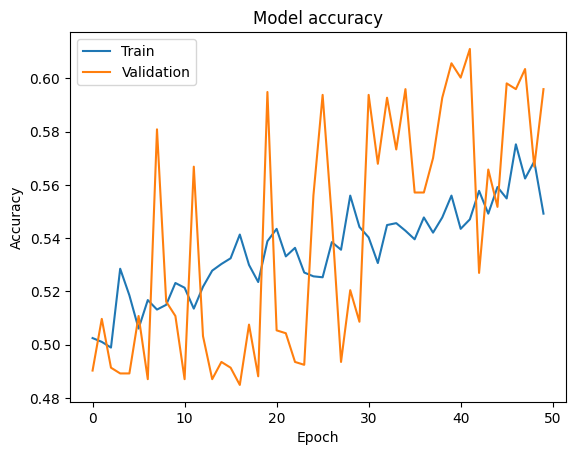

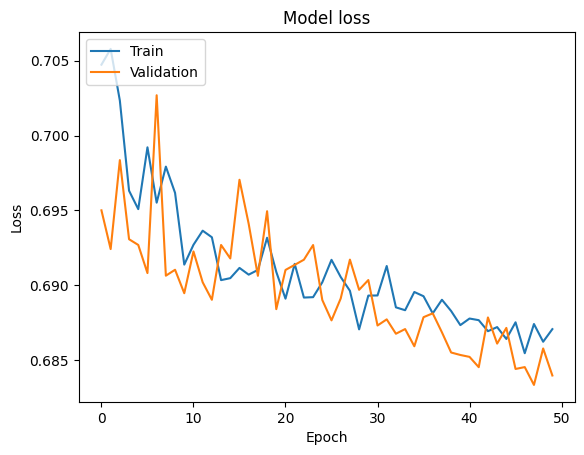

In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


60/60 [==============================] - 8s 123ms/step


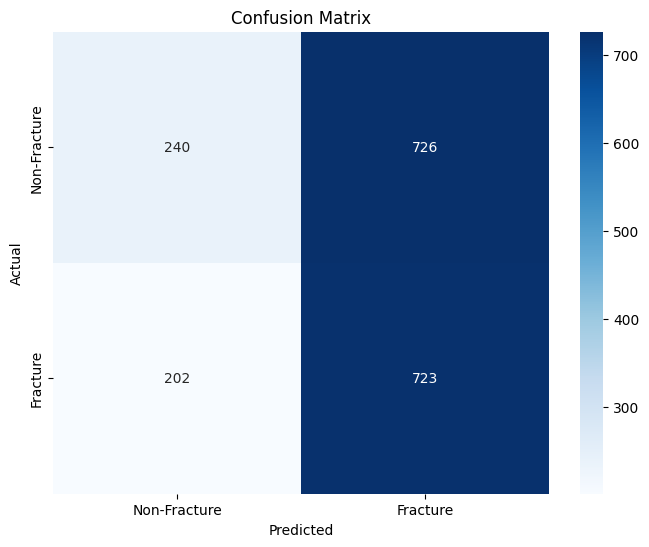

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the saved model
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

# Predict classes for test data
test_generator.reset()
y_pred_prob = model.predict(test_generator)
y_pred = np.round(y_pred_prob)

# Extract ground truth labels
y_true = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Non-Fracture', 'Fracture'], yticklabels=['Non-Fracture', 'Fracture'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


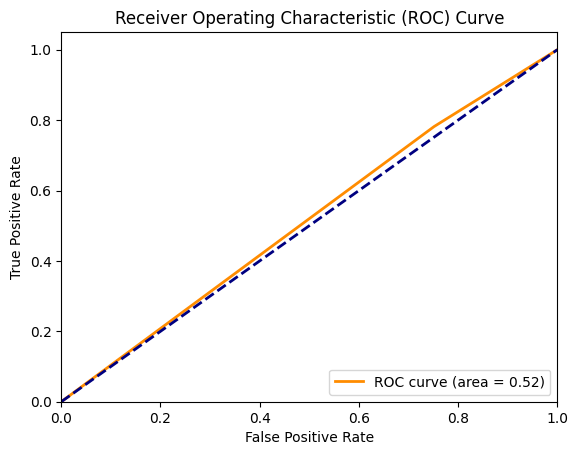

AUC: 0.5150344132952829


In [9]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_generator.classes, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print AUC
print("AUC:", roc_auc)


In [10]:
from sklearn.metrics import classification_report

# Generate predictions
y_pred_classes = np.round(y_pred)

# Generate classification report
report = classification_report(test_generator.classes, y_pred_classes, target_names=test_generator.class_indices)

print(report)


              precision    recall  f1-score   support

    fracture       0.54      0.25      0.34       966
non fracture       0.50      0.78      0.61       925

    accuracy                           0.51      1891
   macro avg       0.52      0.52      0.48      1891
weighted avg       0.52      0.51      0.47      1891

